In [1]:
# GPU 확인
import tensorflow as tf, random, numpy as np, os
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

# 재현성
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# 1) Kaggle CLI
!pip -q install kaggle

# 2) kaggle.json 업로드
from google.colab import files
files.upload()  # kaggle.json 선택

# 3) 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4) 데이터셋 다운로드
!kaggle datasets download -d datasnaek/youtube-new -p /content

# 5) 압축 해제
!unzip -o /content/youtube-new.zip -d /content/youtube-new

# 6) 파일 확인
import os, glob
print(os.listdir('/content/youtube-new'))
print("USvideos.csv 존재?", bool(glob.glob('/content/youtube-new/USvideos.csv')))


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/datasnaek/youtube-new
License(s): CC0-1.0
 64% 129M/201M [00:00<00:00, 1.34GB/s]
100% 201M/201M [00:00<00:00, 897MB/s] 
Archive:  /content/youtube-new.zip
  inflating: /content/youtube-new/CA_category_id.json  
  inflating: /content/youtube-new/CAvideos.csv  
  inflating: /content/youtube-new/DE_category_id.json  
  inflating: /content/youtube-new/DEvideos.csv  
  inflating: /content/youtube-new/FR_category_id.json  
  inflating: /content/youtube-new/FRvideos.csv  
  inflating: /content/youtube-new/GB_category_id.json  
  inflating: /content/youtube-new/GBvideos.csv  
  inflating: /content/youtube-new/IN_category_id.json  
  inflating: /content/youtube-new/INvideos.csv  
  inflating: /content/youtube-new/JP_category_id.json  
  inflating: /content/youtube-new/JPvideos.csv  
  inflating: /content/youtube-new/KR_category_id.json  
  inflating: /content/youtube-new/KRvideos.csv  
  inflating: /content/youtube-n

In [4]:
import pandas as pd, numpy as np, re, string

CSV_PATH = '/content/youtube-new/USvideos.csv'


df = pd.read_csv(CSV_PATH, encoding="ISO-8859-1")
data = df[['title', 'views']].dropna().copy()

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(f"[{re.escape(string.punctuation)}]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

data['title'] = data['title'].map(clean_text)
data['views_log'] = np.log1p(data['views'])

print(data.head(3))
print("rows:", len(data))


                                               title    views  views_log
0                 we want to talk about our marriage   748374  13.525659
1  the trump presidency last week tonight with jo...  2418783  14.698775
2   racist superman rudy mancuso king bach lele pons  3191434  14.975981
rows: 40949


In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 5000
MAX_LEN = 20

X_train_txt, X_val_txt, y_train, y_val = train_test_split(
    data['title'], data['views_log'], test_size=0.2, random_state=SEED, shuffle=True
)

tok = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tok.fit_on_texts(X_train_txt)

X_tr = pad_sequences(tok.texts_to_sequences(X_train_txt), maxlen=MAX_LEN, padding='post')
X_va = pad_sequences(tok.texts_to_sequences(X_val_txt),   maxlen=MAX_LEN, padding='post')
y_tr, y_va = np.array(y_train), np.array(y_val)

X_tr.shape, X_va.shape


((32759, 20), (8190, 20))

In [6]:
BATCH = 32
AUTO = tf.data.AUTOTUNE

ds_tr = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).shuffle(len(X_tr), seed=SEED).batch(BATCH).prefetch(AUTO)
ds_va = tf.data.Dataset.from_tensor_slices((X_va, y_va)).batch(BATCH).prefetch(AUTO)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Input(shape=(MAX_LEN,), dtype='int32'),
    Embedding(input_dim=VOCAB_SIZE, output_dim=64),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20, 64)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,369 (1.50 MB)

 Trainable params: 394,369 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    ds_tr,
    validation_data=ds_va,
    epochs=15,
    callbacks=[es, mc],
    verbose=1
)


Epoch 1/15
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 16.5183 - mae: 2.6416 - val_loss: 1.6155 - val_mae: 0.9886
Epoch 2/15
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 3.1433 - mae: 1.3993 - val_loss: 1.1939 - val_mae: 0.8108
Epoch 3/15
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.6279 - mae: 1.2808 - val_loss: 0.9792 - val_mae: 0.7104
Epoch 4/15
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.3548 - mae: 1.2114 - val_loss: 0.8815 - val_mae: 0.6820
Epoch 5/15
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 2.1453 - mae: 1.1587 - val_loss: 0.9705 - val_mae: 0.7556
Epoch 6/15
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1.9615 - mae: 1.1015 - val_loss: 0.7043 - val_mae: 0.6006
Epoch 7/15
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.6829 - mae: 1.0224 - val_loss: 0.6723 - val_mae: 0.5912
Epoch 8/15
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1.5405 - mae: 0.9767 - val_loss: 0.6012 - val_mae: 0.5405
Epoch 9/15
1024/1024 ━━━━━━━━━━━━

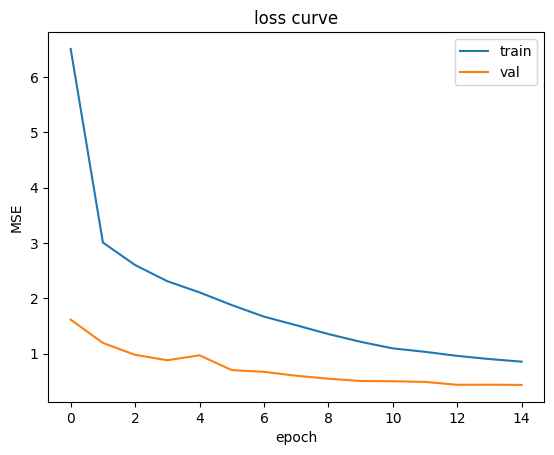

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Val RMSE: 4,972,961.02


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as sk_mse

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('MSE'); plt.title('loss curve')
plt.savefig('/content/loss_curve.png', dpi=150)
plt.show()

y_val_pred = np.expm1(model.predict(X_va).ravel())
y_val_true = np.expm1(y_va)
mse = sk_mse(y_val_true, y_val_pred)
rmse = np.sqrt(mse)
print(f"Val RMSE: {rmse:,.2f}")

with open('/content/model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x+'\n'))


In [13]:
def predict_titles(titles):
    clean = [clean_text(t) for t in titles]
    seq = tok.texts_to_sequences(clean)
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    preds = np.expm1(model.predict(pad).ravel())
    return preds

samples = [
    "React Tutorial for Beginners",
    "I tried the world's spiciest ramen",
    "How to become a millionaire in 2025",
    "BTS Performs Butter at the Grammys",
    "Official Music Video - Taylor Swift"
]
for t, p in zip(samples, predict_titles(samples)):
    print(f"{t} → {p/1e6:.2f} 백만 회")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
React Tutorial for Beginners → 1.41 백만 회
I tried the world's spiciest ramen → 1.10 백만 회
How to become a millionaire in 2025 → 0.43 백만 회
BTS Performs Butter at the Grammys → 0.40 백만 회
Official Music Video - Taylor Swift → 1.65 백만 회


In [14]:
title = input("영상 제목을 입력하세요: ").strip()
if title:
    print(f"예상 조회수: {predict_titles([title])[0]/1e6:.2f} 백만 회")


영상 제목을 입력하세요: faker lol
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
예상 조회수: 0.09 백만 회
